# Solving systems of linear equations
Author: **Jakub Kosmydel**

AGH WIET 2022

### Loading libraries

In [1]:
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt
from time import perf_counter

random.seed(1111)
np.random.seed(2222)

## 1. Gauss-Jordan elimination alghoritm

In [2]:
def solve_gauss_jordan(A, B):
    n = len(A)
    if len(A) != len(A[0]):
        raise Exception("Not squared matrix")

    # Scale the matrix so that the coefficient of maximum magnitude in each row of M is equal to 1
    for i in range(n):
        max_val = max(A[i].min(), A[i].max(), key=abs)
        A[i] /= max_val
        B[i] /= max_val
    
    # Make zeroes below the diagonal
    for j in range(n):
        # Partial pivoting
        # Search for maximum magnitude
        max_pivot_index = np.argmax(A[j:, j]) + j
        min_pivot_index = np.argmin(A[j:, j]) + j
        
        if abs(A[max_pivot_index, j]) < abs(A[max_pivot_index, j]):
            max_pivot_index = min_pivot_index
        
        # Swap the rows
        if max_pivot_index != j:
            A[[j, max_pivot_index]] = A[[max_pivot_index, j]]
            B[j], B[max_pivot_index] = B[max_pivot_index], B[j]
        
        pivot = A[j, j]
        if abs(pivot) < 10 ** -10:
            raise Exception('More than one solution!')
            
        A[j] /= pivot
        B[j] /= pivot
        # Row
        for i in range(j + 1, n):
            val = A[i, j]            
            A[i] -= val * A[j]
            B[i] -= val * B[j]
                
    # Now make zeroes above diagonal
    for j in range(n - 1, -1, -1):
        pivot = A[j, j]
        if abs(pivot) < 10 ** -10: continue
        for i in range(j):
            val = A[i, j] / pivot            
            A[i] -= val * A[j]
            B[i] -= val * B[j]
        
    # Return the solution 
    return B

#### Testing solution
##### Simple tests

In [3]:
A1 = np.array([[2, -2, 1], [1, 3, -2], [3, -1, -1]], dtype=np.double)
B1 = np.array([-3, 1, 2]).astype(np.double)

print(solve_gauss_jordan(A1, B1))
print(np.linalg.solve(A1, B1))

[-1.4 -2.  -4.2]
[-1.4 -2.  -4.2]


In [4]:
A2 = np.array([[-10**-4, 1], [1, 1]]).astype(np.double)
B2 = np.array([1, 2]).astype(np.double)

print(solve_gauss_jordan(A2, B2))
print(np.linalg.solve(A2, B2))

[0.99990001 1.00009999]
[0.99990001 1.00009999]


##### Matrixes of size over 500x500
Function **print_chart(data)** automatically plot chart and check if the solution is correct.

In [5]:
def print_chart(data):
    times = [[], []]
    for dA, dB in data:
        t0 = perf_counter()
        res = np.linalg.solve(dA, dB)
        t_lib = perf_counter() - t0

        t0 = perf_counter()
        res2 = solve_gauss_jordan(dA, dB)
        t_my = perf_counter() - t0
        times[0].append(t_lib)
        times[1].append(t_my)
        
        is_correct = np.allclose(res, res2)
        
        print(f'N: {len(dB)} \tNumpy: {t_lib:.5f}s \tCustom: {t_my:.5f}s \tCorrect: {is_correct}')
        
    labels = [len(dB) for dA, dB in data]
    x = np.arange(len(labels))
    width = 0.2

    fig, ax = plt.subplots()

    rects1 = ax.bar(x - width*0.5, times[0], width, label='Numpy')
    rects2 = ax.bar(x + width*0.5, times[1], width, label='Custom')

    ax.set_title('Execution time of alghoritms')
    ax.set_ylabel('Execution time [s]')
    ax.set_xlabel('Amount of unknowns [n]')
    ax.set_xticks(x, labels)
    ax.legend(loc='lower right')

    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)

    fig.tight_layout()

    plt.show()

N: 100 	Numpy: 0.00171s 	Custom: 0.02980s 	Correct: True
N: 200 	Numpy: 0.04961s 	Custom: 0.12580s 	Correct: True
N: 300 	Numpy: 0.07876s 	Custom: 0.29203s 	Correct: True
N: 400 	Numpy: 0.02354s 	Custom: 0.49916s 	Correct: True
N: 500 	Numpy: 0.01146s 	Custom: 0.83151s 	Correct: True
N: 600 	Numpy: 0.02574s 	Custom: 1.34014s 	Correct: True
N: 700 	Numpy: 0.00925s 	Custom: 1.81321s 	Correct: True
N: 800 	Numpy: 0.01812s 	Custom: 2.39992s 	Correct: True
N: 900 	Numpy: 0.02052s 	Custom: 3.25838s 	Correct: True
N: 1000 	Numpy: 0.02458s 	Custom: 4.01436s 	Correct: True


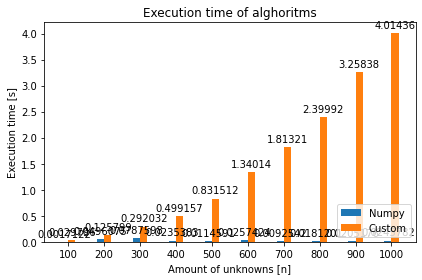

In [6]:
data = [(np.random.randint(1000, size=(x, x)).astype(np.double),
        np.random.randint(1000, size=(x)).astype(np.double)) for x in range(100, 1001, 100)]
print_chart(data)

The bar chart shows that Numpy's algorithm to solve linear equations is much more efficient than the implemented one. The reason for that is that library is written in C which affects the performance of alghoritm. As we can see execution time significantly rise with increasing amount of unknowns - $O(n^{3})$.

## 2. LU decomposition
Implementation of LU decomposition using fixed amount of memory (in-situ).

In [7]:
def lu_decomposition_in_situ(A):
    n = len(A)
    
    for k in range(n):
        for i in range(k + 1, n):
            # Value i divide by
            v = A[i, k]/A[k, k]
            
            # Update rest of the row
            for j in range(k + 1, n):
                A[i, j] = A[i, j] + A[k, j] * -v
                
            # Save the dividing value
            A[i, k] = v

To check correctness of our solution we can divide result to 2 seperate matrixes: L and U.

In [8]:
def lu_decomposition(A):
    lu_decomposition_in_situ(A)
    
    L = np.tril(A, -1) + np.eye(len(A))
    U = np.triu(A)
    
    return L, U

#### LU decomposition test
Does ‖**A**−**LU**‖ equals **0**?

Function **check_LU_decomposition(input_matrix)** is used to check whether our decomposition is correct.

In [9]:
def check_LU_decomposition(input_matrix, print_test=False):
    input_matrix_copy = np.copy(input_matrix)
    l1, u1 = lu_decomposition(input_matrix)

    test1 = input_matrix_copy - np.matmul(l1, u1)
    if print_test:
        print(test1)
        
    is_correct = np.allclose(test1, np.zeros(input_matrix.shape))
    print('Is solution correct?', is_correct)
    return input_matrix, l1, u1, is_correct

##### Simple test

In [10]:
LU1 = np.array([[2, 3, 1, 5], [6, 13, 5, 19], [2, 19, 10, 23], [4, 10, 11, 31]])
in_situ, L, U, is_correct = check_LU_decomposition(LU1, print_test=True)

print('In situ solution:\n', in_situ)
print('Lower matrix:\n', L)
print('Upper matrix:\n', U)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Is solution correct? True
In situ solution:
 [[2 3 1 5]
 [3 4 2 4]
 [1 4 1 2]
 [2 1 7 3]]
Lower matrix:
 [[1. 0. 0. 0.]
 [3. 1. 0. 0.]
 [1. 4. 1. 0.]
 [2. 1. 7. 1.]]
Upper matrix:
 [[2 3 1 5]
 [0 4 2 4]
 [0 0 1 2]
 [0 0 0 3]]


##### Large array with random values

In [11]:
LU2 = np.random.randint(1000, size=(100, 100)).astype(np.double)
a = check_LU_decomposition(LU2)

Is solution correct? True


## Zadanie 3
#### Reading data from file

In [12]:
def loadDiGraphFromFile(path):
    g = nx.read_edgelist(path, data=(("r", float), ("emf", float)), create_using=nx.DiGraph(), nodetype = int)
    return g

#### Calculating currents using Kirchoff's laws
The input argument G is a DiGraph. Each edge should have given parameters:
- **r** - for resistance,
- **emf** - for electromotive force.

This function results in adding parameters to each edge:
- **id** - id of edge (current),
- **current** - calculated current.

#### Overdetermined linear euqation system
Solving electrical circuit using Kirchoff's laws results in overdetermined linear equation system. To deal with it we can multiply each side by the matrix A transposition:
$$Ax=B$$
Is transformed to:
$$A^{T}Ax=A^{T}B$$
After this operation new matrix $A'=A^{T}A$ is squared. We can now solve this like any other equation.

In [13]:
def calculate_currents(G):    
    # Change direction of edge where calculated current is less than 0
    def reverse_negative_currents():
        wrong_directions = []
        for u, v, w in G.edges(data=True):
            if w['current'] < 0:
                wrong_directions.append((v, u))
        G.add_edges_from(wrong_directions)
        for v, u in wrong_directions:
            G[v][u].update(G.get_edge_data(u, v))
            G[v][u]['current'] = -G[v][u]['current']
            G[v][u]['emf'] = -G[v][u]['emf']
            G.remove_edge(u, v)

    current_index = 0

    # Set ids of currents
    for u, v, w in G.edges(data=True):
        w['id'] = current_index
        current_index += 1

    A = np.empty((0,current_index), float)
    B = np.array([])
        
    G_undirected = G.to_undirected()

    # I Kirchhoff law
    for node in G.nodes:
        new_row = np.zeros((1, current_index))
        
        for in_edge in G.in_edges(node):
            new_row[0, G.edges[in_edge]['id']] = 1
            
        for out_edge in G.out_edges(node):
            new_row[0, G.edges[out_edge]['id']] = -1
        
        A = np.append(A, new_row, axis=0)
        B = np.append(B, [0])
    
    # II Kirchhoff law
    for c in nx.cycle_basis(G_undirected):
        new_row = np.zeros((1, current_index))
        total_sem = 0
        cycle_edges = list(zip(c, c[1:] + [c[0]]))
        for u, v in cycle_edges:
            if (u, v) in G.edges:
                edge = G.edges[(u, v)]
                new_row[0, edge['id']] = edge['r']
                total_sem += edge['emf']
            else:
                edge = G.edges[(v, u)]
                new_row[0, edge['id']] = -edge['r']
                total_sem -= edge['emf']
        A = np.append(A, new_row, axis=0)
        B = np.append(B, [total_sem])

    # Calculate overdetermined system of linear equations
    AT = A.T
    A1 = np.matmul(AT, A)
    B1 = np.matmul(AT, B)
    res = np.linalg.solve(A1, B1)
    for i, (u, v, w) in enumerate(G.edges(data=True)):
        G.edges[(u, v)]['current'] = res[i]
        
    reverse_negative_currents()
    return res

#### Testing function
We test our solution by checking whether it's correct according to Kirchoff's laws. 

In [14]:
def is_solution_correct(G):
    for node in G.nodes:
        current = 0
        for in_edge in G.in_edges(node):
            current += G.edges[in_edge]['current']
            
        for out_edge in G.out_edges(node):
            current -= G.edges[out_edge]['current']
        if not np.isclose(current, 0):
            print(f'Currents in node {node} does not sum to zero!')
            return False
        
    G_undirected = G.to_undirected()
    for c in nx.cycle_basis(G_undirected):
        total_sem = 0
        cycle_edges = list(zip(c, c[1:] + [c[0]]))
        for u, v in cycle_edges:
            if (u, v) in G.edges:
                edge = G.edges[(u, v)]
                total_sem += edge['r'] * edge['current']
                total_sem -= edge['emf']
            else:
                edge = G.edges[(v, u)]
                total_sem -= edge['r'] * edge['current']
                total_sem += edge['emf']
        if not np.isclose(total_sem, 0):
            print(f'Emf in cycle {c} does not sum to zero (={total_sem})!')
            return False
        
    return True

#### Graph visualisation function

In [15]:
def visualise_graph(G, show_edges_values=False, pos=None, with_labels=False, line_width=True):
    if pos is None:
        pos = nx.planar_layout(G)

    weights = nx.get_edge_attributes(G,'current').values()
    min_weight = min(weights)
    max_weight = max(weights)
    weight_range = max_weight - min_weight
    widths = list(map(lambda x: (max_weight-x)/weight_range*1+1, weights))       
        
    colors = nx.get_edge_attributes(G,'current').values()
    colors = list(map(lambda x: x + min_weight, colors))
    

    nx.draw_networkx(G, pos, node_color='b', edge_vmin=0, edge_color=colors, width=widths,
                     edge_cmap=plt.cm.get_cmap('Blues'), node_size=1, with_labels=with_labels)
    
    if show_edges_values:
        currents = nx.get_edge_attributes(G, 'current')
        rounded_currents = {k: round(v, 2) for k, v in currents.items()}        
        nx.draw_networkx_edge_labels(G, pos, edge_labels=rounded_currents, verticalalignment='bottom')
    plt.show()

#### Basic test

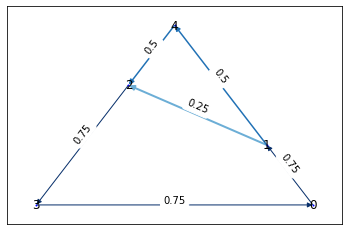

True

In [16]:
G2 = loadDiGraphFromFile("./graphdata/simple2.edgelist")
calculate_currents(G2)

visualise_graph(G2, show_edges_values=True, with_labels=True)
is_solution_correct(G2)

#### Testing useful functions

In [17]:
def add_edge(G, u, v, r=0, e=0, only_set=False):
    if not only_set:
        G.add_edge(u, v)
    G[u][v]['r'] = r
    G[u][v]['emf'] = e
    
def set_all_edges(G, r=10):
    for u, v in G.edges:
        add_edge(G, u, v, r, 0, True)
        
def graph_to_direct(G):
    res = nx.DiGraph()
    for u, v in G.edges:
        res.add_edge(u, v)
    return res

#### Test 1: 2D Grid (10x10)

In [18]:
def generate_2d_grid(size=5, r=10):
    res = nx.DiGraph()

    # Add nodes
    for i in range(size):
        for j in range(size):
            res.add_node((i, j))

    for i in range(size):
        for j in range(size):
            if i < size-1:
                add_edge(res, (i, j), (i+1, j), r)
            if j < size-1:
                add_edge(res, (i, j), (i, j+1), r)
                
    s = (0, 0)
    t = (size-1, size-1)
    v1 = (0, -1)
    v2 = (size, -1)
    v3 = (size, size-1)
    res.add_nodes_from([v1, v2, v3])

    add_edge(res, t, v3, 0)
    add_edge(res, v3, v2, 0)
    add_edge(res, v2, v1, 0)
    add_edge(res, v1, s, 0, 100)

    return res

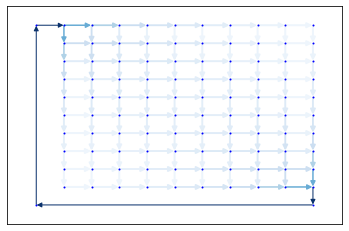

Is correct? True


In [19]:
g_2d_grid = generate_2d_grid(10)

pos_2d_grid = {(x,y):(y,-x) for x,y in g_2d_grid.nodes()}

calculate_currents(g_2d_grid)
visualise_graph(g_2d_grid, pos=pos_2d_grid)
print('Is correct?', is_solution_correct(g_2d_grid))

#### Test 2: Small world

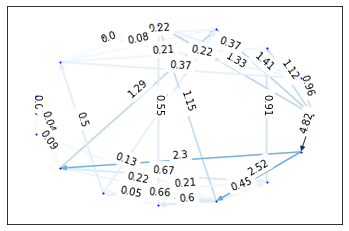

Is correct? True


In [20]:
N = 15
G = graph_to_direct(nx.watts_strogatz_graph(n = N, k = 4, p = 0.5))
pos = nx.circular_layout(G)

set_all_edges(G)
add_edge(G, 0, N-1, 0, 50)

calculate_currents(G)
visualise_graph(G, pos=pos, show_edges_values=True)
print('Is correct?', is_solution_correct(G))

#### Test 3: Cubic graph (3-regular)

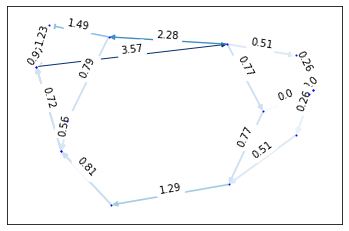

Is correct? True


In [21]:
N = 16
G = graph_to_direct(nx.random_regular_graph(3, N))
pos = nx.spectral_layout(G)

set_all_edges(G)
add_edge(G, 0, N-1, 0, 50)

calculate_currents(G)
visualise_graph(G, pos=pos, show_edges_values=True)
print('Is correct?', is_solution_correct(G))

#### Test 4: Random connected graph (Erdos-Renyi) 

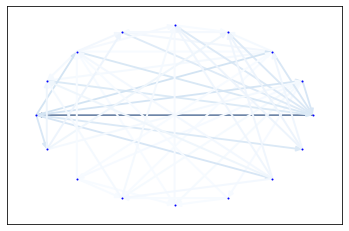

Is correct? True


In [22]:
N = 16
G = graph_to_direct(nx.erdos_renyi_graph(N, 0.4))
pos = nx.circular_layout(G)

set_all_edges(G)
add_edge(G, 0, N-1, 0, 50)

calculate_currents(G)
visualise_graph(G, pos=pos)
print('Is correct?', is_solution_correct(G))

#### Test 5: Two random graphs connected with bridge

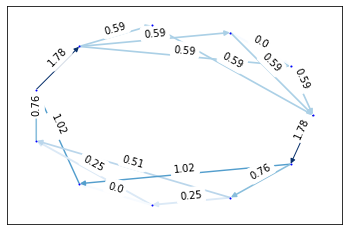

Is correct? True


In [23]:
G = loadDiGraphFromFile("./graphdata/bridge.edgelist")
pos = nx.circular_layout(G)

set_all_edges(G)
add_edge(G, 1, 7, 0, 50)

calculate_currents(G)
visualise_graph(G, pos=pos, show_edges_values=True)
print('Is correct?', is_solution_correct(G))

### Conclusion

W końcowym rozwiązaniu **kierunek prądu** jest pokazany zgodnie z kierunkiem krawędzi w której płynie. Po obliczeniu prądów w każdej krawędzi, jeżeli zajdzie taka potrzeba i prąd jest ujemny, zamieniamy kierunek krawędzi wraz ze znakami prądu i EMF.


**Poprawność rozwiązania** jest sprawdzana z wykorzystaniem praw Kirchoff'a. Po obliczeniu prądów zostaje sprawdzone czy suma prądów wpływających do wierzchołka jest równa 0 oraz czy suma napięć w cyklu jest równa 0.


**Cykle proste** są wyznaczane z użyciem biblioteki do Pythona NetworkX, która posiada wbudowaną funkcję. Jednak przed tego dokonaniem graf jest tymczasowo zamieniany na nieukierunkowany, aby nie pominąć żadnego cyklu.